#### 2-D Range Tree

Given a set of 2-D points, a 2-D range tree is a 2-level BST. More specifically, the first/outer level is a weight-balanced BST on the points using the x-coordinates as the key. For each internal node $u$ in this first-level BST, let $P(u)$ denote the set of points contained in the subtree rooted at $u$. Then inside each node $u$ is contained a secondary weight-balanced BST on only the points $P(u)$ using the y-cordinates as the key.

The constriction of the first level is the same as that for the 1-d range tree, with the points sorted by their x-coordinate.

To efficiently construct the secondary level trees, we first sort all points in $P$ by their y-coordinates. Let $P_y$ denote this sorted list. Then we can construct the secondary trees in a top-down manner, starting from the root node. Let $u$ be the root node. We construct the secondary level tree inside $u$ using $P_y$. Then we create two empty lists $P_{yL}$ and $P_{yR}$. We scan $P_y$ from beginning to end, and for each point $p \in P_y$, if $p.x < u.x$, then we append $p$ to $P_{yL}$, otherwise we append $p$ to $P_{yR}$. Thus $P_{yL}$ and $P_{yR}$ contain all the points in $P(u.left)$ and $P(u.right)$ respectively, sorted by their y-coordinates. We recursively apply this procedure to the left and right children of $u$, using $P_{yL}$ to construct the secondary level tree inside the left child and $P_{yR}$ for the right child. The psuedo-code for this recursive secondary-level construction is shown below.


```
construct_secondary_trees(u, Py):
  if u is a leaf: 
    return
  else:
    construct_wbst(u, P_y) // constructs a WBST on points P_y and stores it in u
    scan Py to create P_yL and P_yR 
    construct_secondary_trees(u.left, P_yL)  // recursive call on left child
    construct_secondary_trees(u.right, P_yR) // recursive call on right child  
    return 
```




In [140]:
from collections import defaultdict
from graphviz import Digraph, Source
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def add_nodes_edges(graph, node, counter=0):
    if node is not None:
        root = str(counter)
        graph.node(root, str(node.data), fontsize='10')
        if node.left is not None:
            left = str(counter + 1)
            graph.edge(root, left)
            counter = add_nodes_edges(graph, node.left, counter + 1)
        else:
            if node.right is not None:
                # Add a dummy node if the node has no left child
                left = str(counter + 1)
                graph.node(left, "null")
                graph.edge(root, left)
                counter += 1

        if node.right is not None:
            right = str(counter + 1)
            graph.edge(root, right)
            counter = add_nodes_edges(graph, node.right, counter + 1)
        else:
            if node.left is not None:    
                # Add a dummy node if the node has no right child
                right = str(counter + 1)
                graph.node(right, "null")
                graph.edge(root, right)
                counter += 1

    return counter

def visualize_tree(root):
    graph = Digraph()
    add_nodes_edges(graph, root)
    return Source(graph.source)  


def plot_points(P, Q, found_points):
    Px = [p[0] for p in P]
    Py = [p[1] for p in P]

    # set figure size 
    plt.figure(figsize=(8, 8))

    # plot the points on a 2D plane
    plt.plot(Px, Py, 'o', markersize=5)
    plt.xlabel('x')
    plt.ylabel('y')

    # create a rectangle
    x1, x2 = Q[0]
    y1, y2 = Q[1]
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    # add the rectangle to the plot
    plt.gca().add_patch(rect)

    # draw thin circle around each reported point on the plot
    for p in found_points:
        plt.plot(p[0], p[1], '+', markersize=4, markerfacecolor='none', markeredgecolor='r')

    plt.show()
    

In [156]:
class Node:
    def __init__(self, key=None, data=None, parent=None, left=None, right=None):
        self.key = key
        self.data = data
        self.parent = parent
        self.left = left
        self.right = right
        self.secondary_tree = None

class range2d:
    def __init__(self, P):
        self.size = len(P)
        self.root = self.construct_tree(P)

    @property
    def get_root(self):
        return self.root

    # bst search for a given key
    def search(self, key):
        node = self.root
        while node is not None:
            if key < node.key:
                node = node.left
            elif key > node.key:
                node = node.right    
            else:
                return node    
        return None 

    # function for constructing a weight-balanced binary search tree on a set of keys
    def construct_tree(self, P):    
        # create two copies of the points, one sorted by x-coordinates and the other by y-coordinates
        P_x = sorted(P, key=lambda x: x[0])
        P_y = sorted(P, key=lambda x: x[1])
        # recursively build the first level tree
        root = self.wbst(P_x, 0, len(P_x)-1, l=0)
        # build the secondary level trees top-down, starting from the root
        self.construct_secondary_tree(root, P_y)    
        
        return root
    
    def construct_secondary_tree(self, u, P_y):
        # stop if u is a leaf node
        if u.left is None and u.right is None:
            return

        # construct a wbst on the y-coordinates of the points in P_y inside node u
        u.secondary_tree = self.wbst(P_y, 0, len(P_y)-1, l=1)
        # scan the points in P_y and assign them to the left or right subtree of u
        P_yL = []
        P_yR = []
        for p in P_y:
            if p[0] < u.data[0]:
                P_yL.append(p)
            else:
                P_yR.append(p)

        # recursively build the secondary trees for the left and right children of u
        if u.left is not None:
            self.construct_secondary_tree(u.left, P_yL)
        if u.right is not None:
            self.construct_secondary_tree(u.right, P_yR)  


    # recursive function for constructing a weight-balanced binary search tree
    def wbst(self, P, lo, hi, l):
        # find the median of the sorted keys
        m = (lo+hi+1) // 2
        # create a node with the median key
        node = Node(key=P[m][l], data=P[m])
        # recursively build the left subtree
        if lo < m:
            node.left = self.wbst(P, lo, m-1, l)
            node.left.parent = node
        if hi > m:
            node.right = self.wbst(P, m+1, hi, l)
            node.right.parent = node

        return node     
 
    # report all points in the 2d range Q = [x1,x2] x [y1,y2]
    def report_range_2d(self, Q):
        x1, x2 = Q[0]
        y1, y2 = Q[1]
        #print(f"Q = [{x1}, {x2}] x [{y1}, {y2}]")

        # first find the successor(x1) and predecessor(x2)
        ax = self.find_successor(self.root, x1)
        bx = self.find_predecessor(self.root, x2)
        print(f"ax = {ax.data if ax is not None else None}, bx = {bx.data if bx is not None else None}")


        if ax is None or bx is None:
            return []
        
        # find LCA in the primary tree
        lca = self.find_lca(self.root, ax, bx)

        range_nodes = []

        # check if the LCA is in the range [y1, y2]
        if lca.data[1] >= y1 and lca.data[1] <= y2:
            range_nodes.append(lca)

        # walk up from ax to LCA to find nodes in the path which are in the range [x1, x2]
        node = ax
        while node != lca:
            if node.key >= x1:
                #print(f"Found node {node.data} in the x-range [{x1}, {x2}]")
                # check if the node is also in the range [y1, y2]
                if node.data[1] >= y1 and node.data[1] <= y2:
                    #print(f"Found node {node.data} in the y-range [{y1}, {y2}]")
                    range_nodes.append(node)
                # perform 1d range query on the secondary tree rooted at the right child node
                if node.right is not None:
                    if node.right.secondary_tree is None:
                        # if right child is a leaf node, then just check if it is in the range [y1, y2]
                        if node.right.data[1] >= y1 and node.right.data[1] <= y2:
                            #print(f"Found node {node.right.data} in the y-range [{y1}, {y2}]")
                            range_nodes.append(node.right)
                    else:    
                        #print(f"Secondary tree rooted at right-child {node.right.secondary_tree.data} is:")
                        #display(visualize_tree(node.right.secondary_tree))
                        range_nodes_y = self.report_range_1d(node.right.secondary_tree, y1, y2)
                        range_nodes.extend(range_nodes_y)
                        #print(f"Found nodes in the y-range [{y1}, {y2}] : {[n.data for n in range_nodes_y]}")

            node = node.parent

        # walk up from bx to LCA to find nodes in the path which are in the range [x1, x2]
        node = bx
        while node != lca:
            if node.key <= x2:
                #print(f"Found node {node.data} in the x-range [{x1}, {x2}]")
                # check if the node is also in the range [y1, y2]
                if node.data[1] >= y1 and node.data[1] <= y2:
                    #print(f"Found node {node.data} in the y-range [{y1}, {y2}]")
                    range_nodes.append(node)
                # perform 1d range query on the secondary tree rooted at the left child node
                if node.left is not None:
                    if node.left.secondary_tree is None:
                        # if left child is a leaf node, then just check if it is in the range [y1, y2]
                        if node.left.data[1] >= y1 and node.left.data[1] <= y2:
                            #print(f"Found node {node.left.data} in the y-range [{y1}, {y2}]")
                            range_nodes.append(node.left)
                    else:        
                        #print(f"Secondary tree rooted at left-child {node.left.secondary_tree.data} is:")
                        #display(visualize_tree(node.left.secondary_tree))
                        range_nodes_y = self.report_range_1d(node.left.secondary_tree, y1, y2)
                        range_nodes.extend(range_nodes_y)
                        #print(f"Found nodes in the y-range [{y1}, {y2}] : {[n.data for n in range_nodes_y]}")

            node = node.parent

        range_points = [node.data for node in range_nodes]
        print(f"Points found in the range [{x1}, {x2}] x [{y1}, {y2}] are: {range_points}")

        return range_points

    
    # report all keys in the 1d range [x1, x2] contained in the tree rooted at the given node
    def report_range_1d(self, node, x1, x2, get_subtree_nodes=False):
        # first find the successor(x1) and predecessor(x2)
        a = self.find_successor(node, x1)
        b = self.find_predecessor(node, x2)

        if a is None or b is None:
            return []
        
        # find LCA
        lca = self.find_lca(node, a, b)

        # walk up from a to LCA, collecting all keys in the path which are in the range [x1, x2]
        range_nodes_left = []
        node = a
        while node != lca:
            if node.key >= x1:
                range_nodes_left.append(node)
                if node.right is not None:
                    range_nodes_left.extend(self.report_subtree(node.right))

            node = node.parent

        # walk up from b to LCA, collecting all keys in the path which are in the range [x1, x2]
        range_nodes_right = []
        node = b
        while node != lca:
            if node.key <= x2:
                range_nodes_right.append(node)
                if node.left is not None:
                    range_nodes_right.extend(self.report_subtree(node.left))

            node = node.parent

        range_nodes_right.reverse()
        range_nodes = range_nodes_left + [lca] + range_nodes_right
        return range_nodes


    # report all nodes in the subtree rooted at a given node
    def report_subtree(self, node):
        subtree_nodes = [node]
        # perform level order traversal/BFS to get all nodes in the subtree
        queue = [node]
        while len(queue) > 0:
            node = queue.pop(0)
            if node.left is not None:
                queue.append(node.left)
                subtree_nodes.append(node.left)
            if node.right is not None:
                queue.append(node.right)
                subtree_nodes.append(node.right)

        return subtree_nodes    


    # find lowest common ancestor of two nodes in the tree rooted at the given node
    def find_lca(self, node, a, b):
        while True:
            if node.key > a.key and node.key > b.key:
                node = node.left
            elif node.key< a.key and node.key < b.key:
                node = node.right
            else:
                return node        

    # find predecessor of a given key in the tree rooted at the given node
    def find_predecessor(self, node, key):
        predecessor = None
        while node is not None:
            if key < node.key:
                node = node.left
            elif key > node.key:
                predecessor  = node
                node = node.right    
            else:
                return node    
        
        return predecessor
    
    # find successor of a given key in the tree rooted at the given node
    def find_successor(self, node, key):
        successor = None
        while node is not None:
            if key < node.key:
                successor = node
                node = node.left
            elif key > node.key:
                node = node.right    
            else:
                return node    
        
        return successor



In [159]:
random.seed(10)

# draw random integers between 0 and 100 without replacement
N = 100
Px = random.sample(range(1,2000), N)
Py = random.sample(range(1,2000), N)
P = list(zip(Px, Py))
tree = range2d(P)

#visualize_tree(tree.get_root)

ax = (512, 1265), bx = (893, 1066)
Points found in the range [500, 900] x [125, 570] are: [(581, 357), (581, 357), (740, 245), (672, 563), (769, 497)]


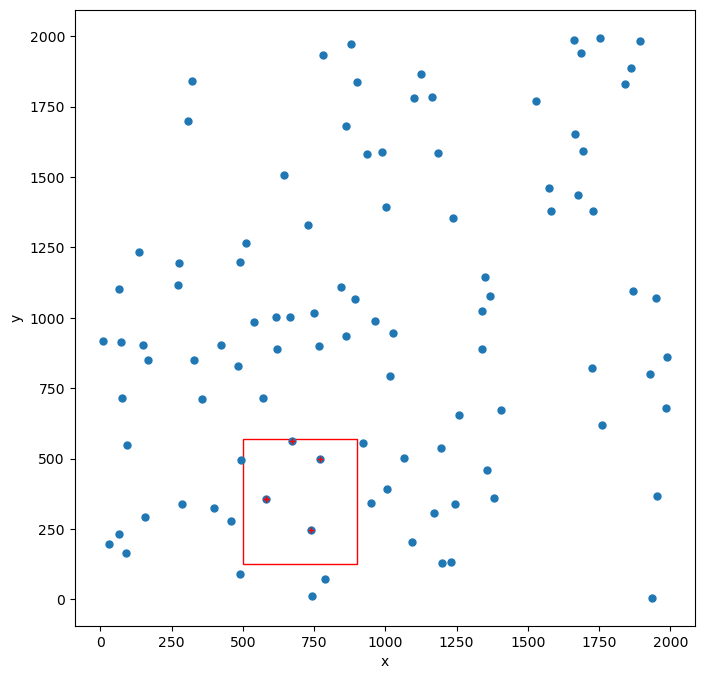

In [160]:
# set the 2D range query
Q = [(500, 900), (125, 570)]

# report all points in the 2D range Q
points = tree.report_range_2d(Q)

plot_points(P, Q, points)
